In [1]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

#SBND imports
s0 = time() 
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.general import utils
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP
from pyanalib.panda_helpers import multicol_concat
from sbnd.stats.stats import build_matrix

#Constants
from sbnd.numu.numu_constants import *
from sbnd.flux.prism import PRISM_BINS,make_prism_plot
from sbnd.constants import *
from sbnd.detector.volume import plot_volume_boundary

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 101.08 s


In [2]:
#Constants/variables
CUT_MODE = 'roc_cont'
#DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_82_02_01_pds_gain'
FNAME = f'nom_processed_{CUT_MODE}.df'
HDR_FNAME = 'nom.df'
#FNAME = f'single_processed_{CUT_MODE}.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
#FNAME = f'all_processed_{CUT_MODE}.df'
#FNAME = 'all_processed_roc.df'
#HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
# NOM_POT = 6e20 # proposal 1
# LABEL = 'SBND Work in Progress\n6e20 POT'
# PLOT_DIR = f'Plots/6e20/reco_{plotters.day}_{CUT_MODE}/leading_muon'

NOM_POT = 10e20 # proposal 2
LABEL = 'SBND Simulation\nPreliminary'
PLOT_DIR = f'Plots/10e20_preliminary/reco_{plotters.day}_{CUT_MODE}/leading_muon'

SAVE_PLOT = True

plt.style.use('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana/sbnd/plotlibrary/plot.mplstyle')

In [3]:
#Get data and POT
pfp = PFP.load(f'{DATA_DIR}/{FNAME}','pfp'
               ,prism_bins=PRISM_BINS
               ,momentum_bins=MOMENTUM_BINS
               ,costheta_bins=COSTHETA_BINS
               ,pot=NOM_POT)
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice'
                    ,prism_bins=PRISM_BINS
                    ,pot=NOM_POT)
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 134.14
--scaling to POT: 7.45e+18 -> 1.00e+21
--scaling to POT: 7.45e+18 -> 1.00e+21


In [4]:
CUTS = ['cosmic','fv','trk','muon']
pur,eff,f1 = slc.get_pur_eff_f1(['cosmic','fv','trk','muon','cont'])
pur,eff,f1

(array([0.05938773, 0.66998959, 0.81843083, 0.86394197, 0.92476599,
        0.94121271]),
 array([1.        , 0.70374904, 0.56825883, 0.53371953, 0.46217073,
        0.23379604]),
 array([1.        , 0.6864545 , 0.67077812, 0.65982028, 0.61632195,
        0.37455348]))

(array([0.22224323, 0.66998959, 0.81309471, 0.85877658, 0.92076491]),

 array([1.        , 0.7206205 , 0.61017594, 0.57319694, 0.49579174]),
 
 array([1.        , 0.69438333, 0.69717004, 0.68751007, 0.64453142]))

## 2 Apply cuts, get leading muon, assign binnings

In [5]:
slc_cut = slc.copy()
for cut in CUTS:
    slc_cut.apply_cut(cut)
#concat best_muon df with weights df
df = multicol_concat(slc_cut.data.best_muon,pd.DataFrame(slc_cut.data.genweight),axis=1)
df = multicol_concat(df,pd.DataFrame(slc_cut.data.truth.event_type),axis=1)
muon = PFP(df
              ,pot=NOM_POT
              ,prism_bins=PRISM_BINS
              ,momentum_bins=MOMENTUM_BINS
              ,costheta_bins=COSTHETA_BINS)
              

Applied cut on key: cut.cosmic (770,277 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 31,762)
Applied cut on key: cut.trk (31,762 --> 28,260)
Applied cut on key: cut.muon (28,260 --> 22,862)


In [ ]:
#Assign costheta bins - we do this after cuts to save some time - may postprocess this in the future
muon.assign_costheta_bins()
muon.assign_costheta_bins(key='truth.p.costheta',assign_key='truth.costheta_bin')

#Momentum bin
muon.assign_momentum_bins()
muon.assign_momentum_bins(key='truth.p.genp.tot',assign_key='truth.momentum_bin')

#Prism bin
muon.assign_prism_bins()
muon.assign_prism_bins(key='truth.p.prism_theta',assign_key='truth.prism_bin')

In [7]:
#Split by event type
bins = EVENT_IDS
total_events = np.sum(muon.data.genweight)
muon_events = muon.get_split(bins,'event_type')
muon_weights = [m.genweight for m in muon_events]
muon_labels = [f'{EVENT_NAMES[i+1]} ({np.sum(m.genweight)/total_events*100:.2f}%)' for i,m in enumerate(muon_events)]
muon_labels

['$\\nu_\\mu$ CC (92.48%)',
 '$\\nu$ NC (2.71%)',
 '$\\nu_e$ CC (0.11%)',
 'Cosmic (0.90%)',
 'Non AV $\\nu$ (3.80%)']

## 3 PRISM

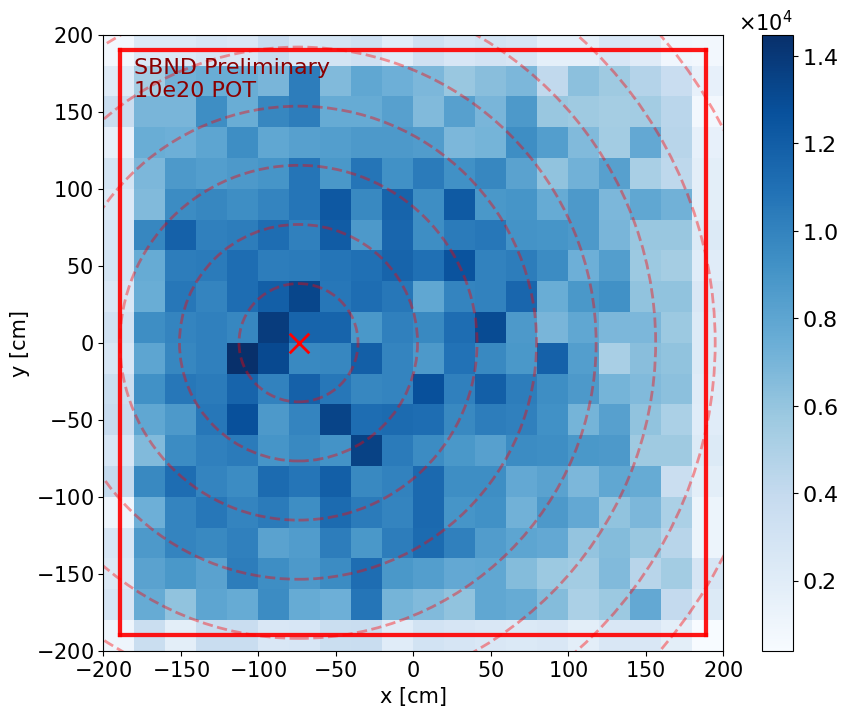

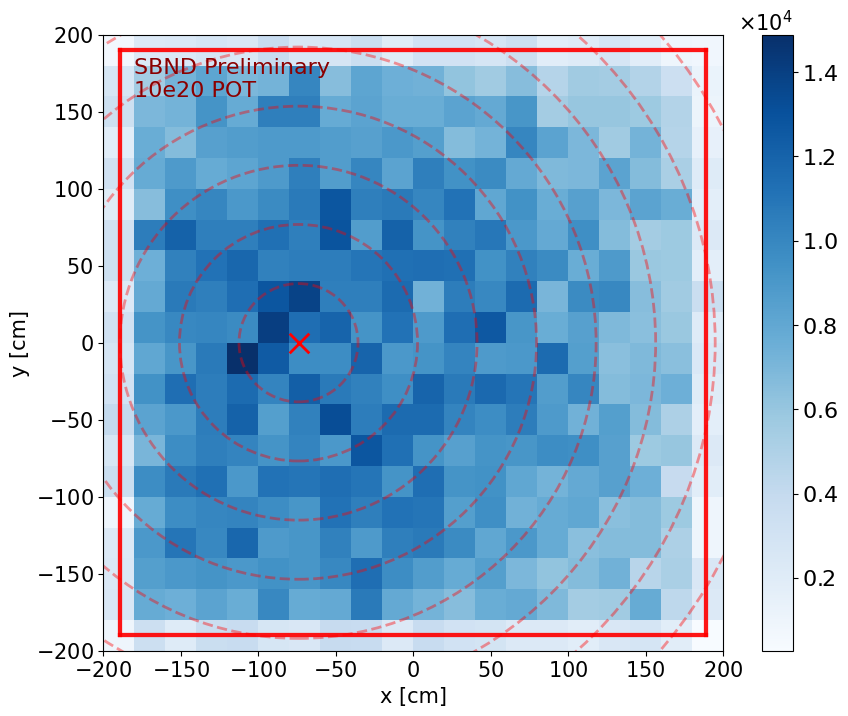

In [71]:
weights = muon.data.genweight
bins = np.arange(-200,220,20)
for i,t in enumerate([True,False]):
    if t:
        pos = muon.data.truth.p.start
        fname = 'truth_prism'
    else:
        pos = muon.data.start
        fname = 'reco_prism'
    fig,ax=make_prism_plot(pos,weights=weights,bins=bins,cmap='Blues')
    ax.set_title('')
    ax = plot_volume_boundary(ax,lw=3,color='red',alpha=0.7)
    ax.set_xlim(-200,200)
    ax.set_ylim(-200,200)
    #plotters.set_style(ax)
    ax.text(0.05,0.9,LABEL,transform=ax.transAxes,fontsize=16,color='darkred')
    #plotters.add_label(ax,LABEL,where='topright',color='white',size=12)
    if SAVE_PLOT:
        plotters.save_plot(fname,fig=fig,folder_name=PLOT_DIR)
        #plt.close()

## 4 Single var distibutions

plot directory: Plots/10e20_preliminary/reco_2024_11_26_roc_cont/leading_muon


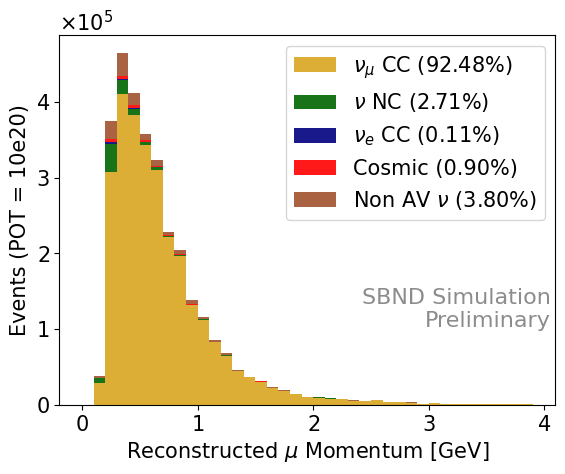

In [8]:
for i,dens in enumerate(['']):
    fig,ax = plt.subplots()
    h = ax.hist([m.p for m in muon_events],
                bins=np.arange(0,4,0.1),
                weights=muon_weights,
                histtype='barstacked',
                lw=3,
                alpha=0.9,
                label=muon_labels,
                color=EVENT_COLORS[1:],
                density=True if i == 1 else False, #set density
        )
    ax.legend()
    #ax.set_xlabel(r'$p_{\mu,reco}$ [GeV]')
    ax.set_xlabel(r'Reconstructed $\mu$ Momentum [GeV]')
    ax.set_ylabel('Normalized events' if i == 1 else f'Events (POT = {NOM_POT/1e20:.0f}e20)')
    #ax.set_title(f'Leading Muon Momentum')# ({round(muon.data.genweight.sum()):,} events)')
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    #plotters.set_style(ax,legend_loc='upper right')
    plotters.add_label(ax,LABEL,alpha=0.9,fontsize=16,color='gray',where='bottomishright')
    if SAVE_PLOT:
        plotters.save_plot(f'momentum',fig=fig,folder_name=PLOT_DIR)
        #plt.close()
print(f'plot directory: {PLOT_DIR}')

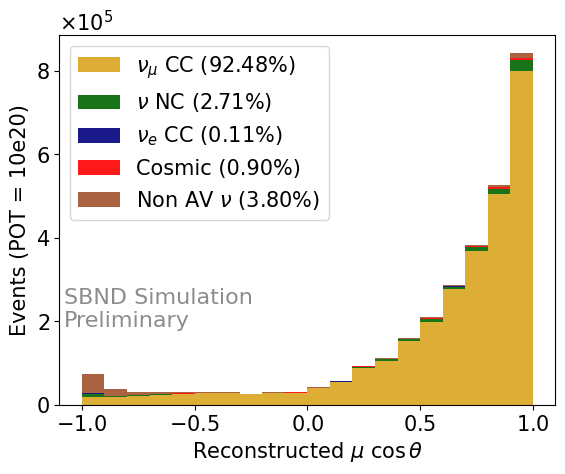

In [9]:
for i,dens in enumerate(['']):
    fig,ax = plt.subplots()
    h = ax.hist([m.costheta for m in muon_events],
                bins=np.arange(-1,1.1,0.1),
                weights=muon_weights,
                histtype='barstacked',
                lw=3,
                alpha=0.9,
                color=EVENT_COLORS[1:],
                label=muon_labels,
                density=True if i == 1 else False, #set density
        )
    ax.legend()
    #ax.set_xlabel(r'$\cos\theta_{\mu,reco}$')
    ax.set_xlabel(r'Reconstructed $\mu$ $\cos\theta$')
    ax.set_ylabel('Normalized events' if i == 1 else f'Events (POT = {NOM_POT/1e20:.0f}e20)')
    #ax.set_title(fr'Leading Muon $\cos\theta$ ({round(muon.data.genweight.sum()):,} events)')
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    #plotters.set_style(ax,legend_loc='upper left')
    plotters.add_label(ax,LABEL,alpha=0.9,fontsize=16,color='gray',where='bottomishleft')
    if SAVE_PLOT:
        plotters.save_plot(f'costheta',fig=fig,folder_name=PLOT_DIR)
        #plt.close()

## 5 Multivar distributions

### 5.1 PRISM

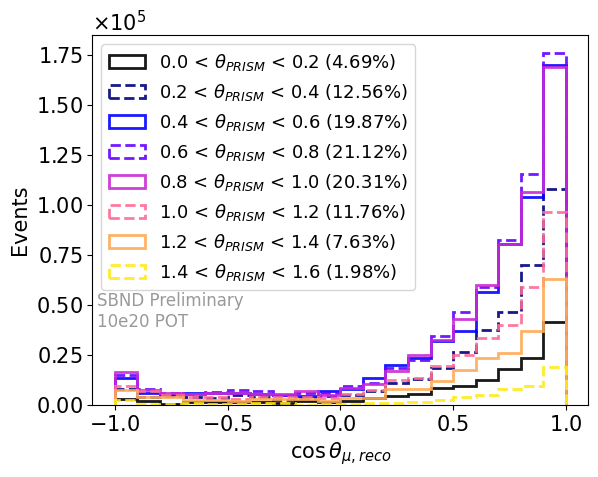

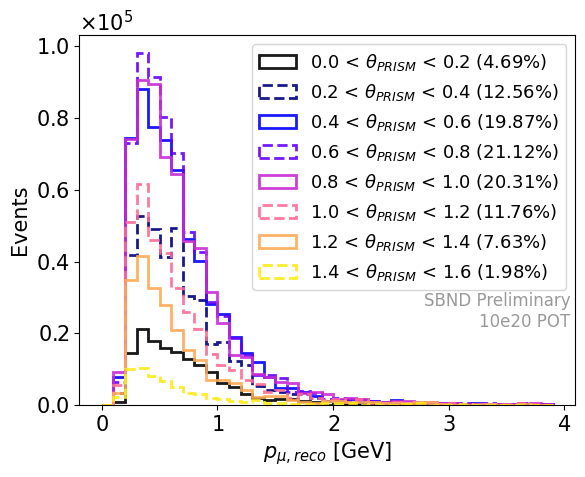

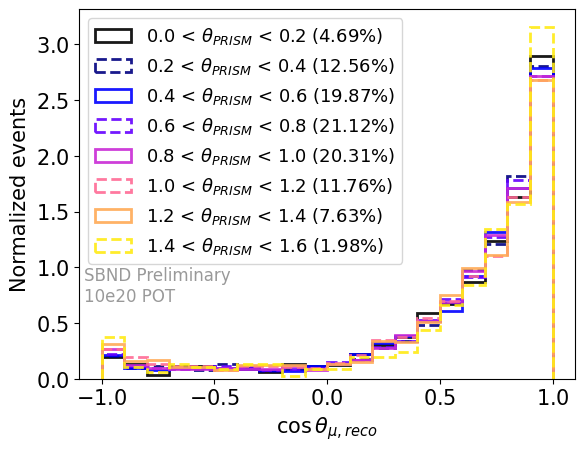

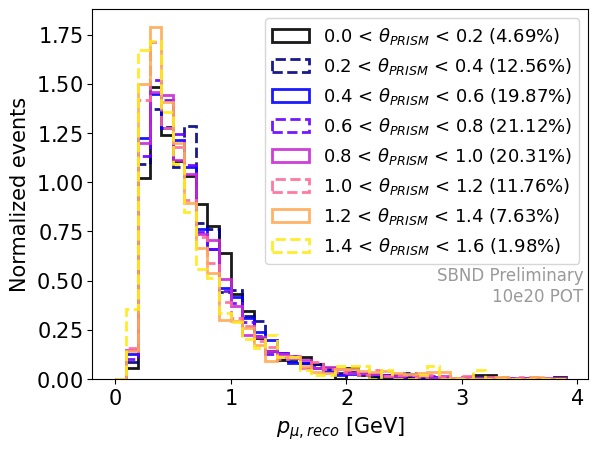

In [79]:
#Make list of colors from colormap the same length as thetas
colors = plotters.get_colors('gnuplot2',len(PRISM_BINS)-1)

#Prism plot for muon kinematics - let's do this all at once to avoid double counting errors
for i,dens in enumerate(['','_dens']):
    #Figures forr angles
    fig_costheta,ax_costheta = plt.subplots()
    
    #Figures for momenta
    fig_momentum,ax_momentum = plt.subplots()
    
    #Make a list for repeated tasks
    axs = [ax_costheta,ax_momentum]
    
    #Labels for figures
    labels = [None]*(len(PRISM_BINS)-1)
    
    for j,_ in enumerate(PRISM_BINS):
        if PRISM_BINS[j] == PRISM_BINS[-1]: break #skip last bin to avoid range errors
        #Mask prism bins
        muon_inrange = muon.data[muon.data.prism_bin == j]
        
        #Set labels
        labels[j] = f'{round(PRISM_BINS[j],2)} < ' + r'$\theta_{PRISM}$'\
        + f' < {round(PRISM_BINS[j+1],2)} ({np.sum(muon_inrange.genweight)/total_events*100:.2f}%)'
        
        #Make histograms
        ax_costheta.hist(muon_inrange.costheta, #cos theta values
            bins=np.arange(-1,1.1,0.1),
            weights=muon_inrange.genweight,
            histtype='step',
            lw=2,
            alpha=0.9,
            label=labels[j],
            density=True if i == 1 else False, #set density
            linestyle='-' if j % 2 == 0 else '--', #alternate linestyle to help with visibility
            color=colors[j],
            )
        ax_momentum.hist(muon_inrange.p, #momentum values
            bins=np.arange(0,4,0.1),
            weights=muon_inrange.genweight,
            histtype='step',
            lw=2,
            alpha=0.9,
            label=labels[j],
            density=True if i == 1 else False, #set density
            color=colors[j],
            linestyle='-' if j % 2 == 0 else '--', #alternate linestyle to help with visibility
            )
    
    
    #Set xlabels
    ax_costheta.set_xlabel(r'$\cos\theta_{\mu,reco}$')
    ax_momentum.set_xlabel(r'$p_{\mu,reco}$ [GeV]')
    
    #Set labels
    plotters.add_label(ax_costheta,LABEL,alpha=0.8,fontsize=12,color='gray',where='bottomishleft')
    plotters.add_label(ax_momentum,LABEL,alpha=0.8,fontsize=12,color='gray',where='bottomishright')
    
    for k,ax in enumerate(axs):
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_ylabel('Normalized events' if i == 1 else 'Events')
        ax.legend(fontsize=13)
    #plotters.set_style(ax_costheta,legend_size=11,legend_loc='upper left')
    #plotters.set_style(ax_momentum,legend_size=11,legend_loc='upper right')
    if SAVE_PLOT:
        plotters.save_plot(f'prism_muon_costheta{dens}',fig=fig_costheta,folder_name=PLOT_DIR)
        plotters.save_plot(f'prism_muon_momentum{dens}',fig=fig_momentum,folder_name=PLOT_DIR)
        #plt.close('all')


### 5.2 Reco vs True Differential Plots

In [80]:
np.unique(muon.data.momentum_bin,return_counts=True),muon.data.truth.momentum_bin,np.sum(muon.data.p.isna())#,len(muon.data.truth.p.isna())

((array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
  array([ 156, 3082, 6537, 5074, 3223, 1894, 1144,  614,  729,  409])),
 __ntuple  entry  rec.slc..index
 0         0      0                 4
           13     0                 1
           22     1                 1
           23     1                 4
           25     1                 1
                                   ..
           87088  1                 2
           87098  1                 3
           87099  0                 2
           87102  0                 2
           87103  1                 0
 Name: momentum_bin, Length: 22862, dtype: category
 Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < -1],
 0)

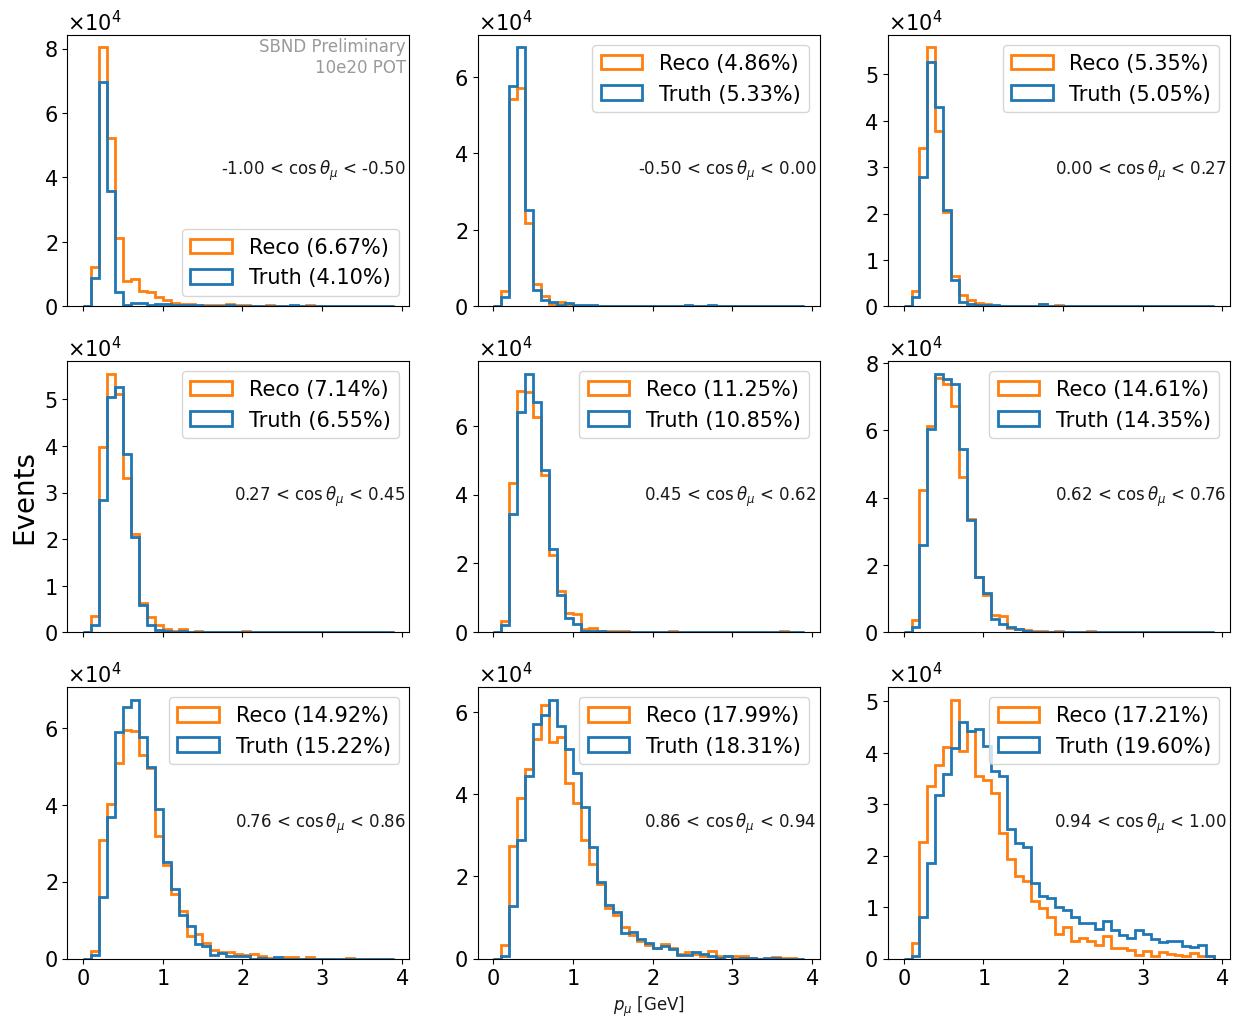

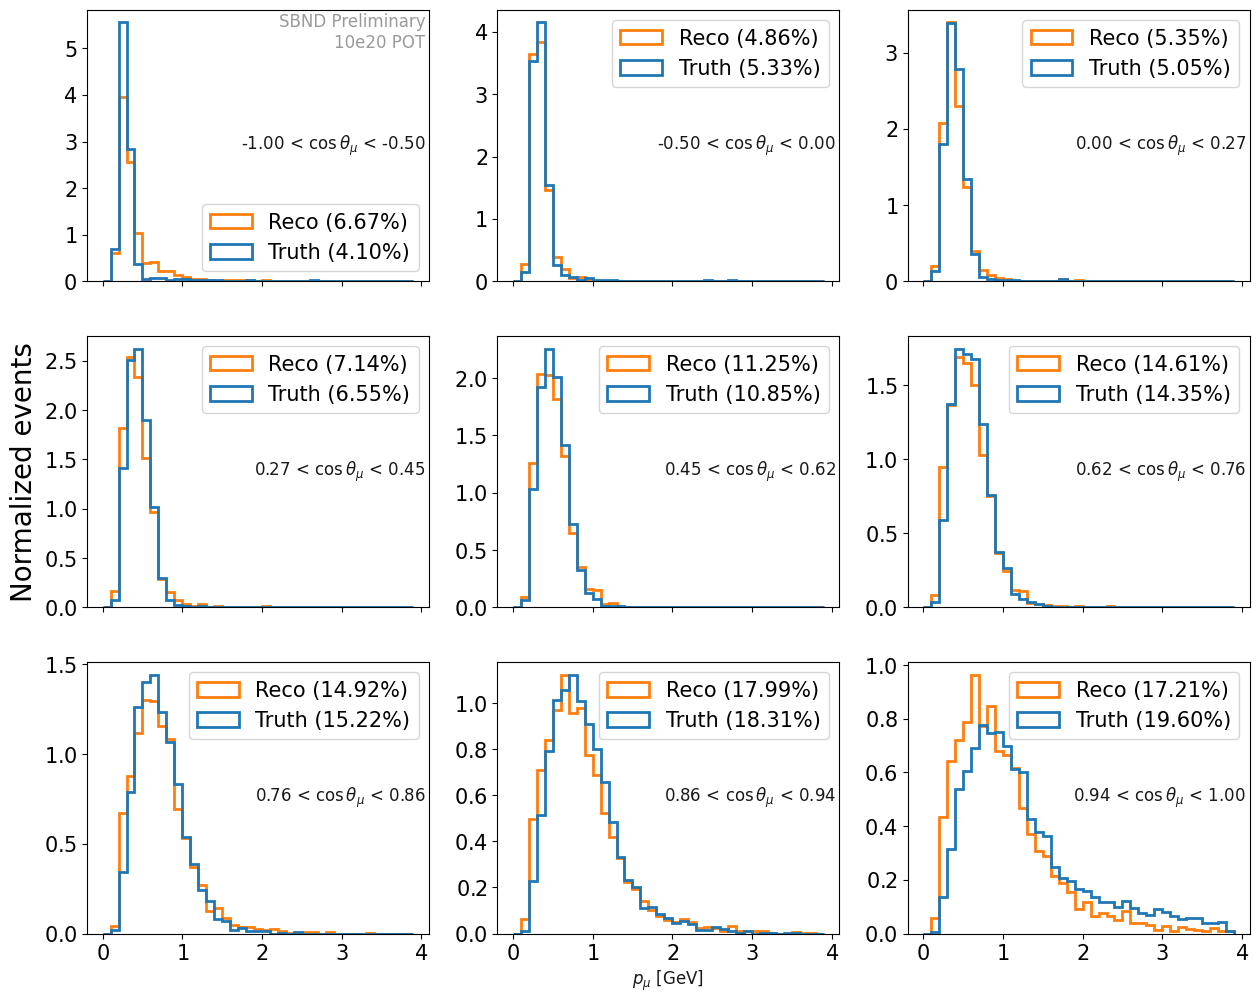

In [82]:
for j,dens in enumerate(['','_dens']):
  fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,12),sharex=True)
  for i,ax in enumerate(axs.flatten()):
    #Get muons within theta bins
    truth_muon_inrange = muon.data[(muon.data.truth.costheta_bin == i)]
    reco_muon_inrange = muon.data[(muon.data.costheta_bin == i)]
    
    #Get momenta
    ps_truth = truth_muon_inrange.truth.p.genp.tot
    ps_reco = reco_muon_inrange.p
    
    #Get weights
    weights_truth = truth_muon_inrange.genweight
    weights_reco = reco_muon_inrange.genweight
    
    #Get number of events from weights
    truth_inrange_count = np.sum(weights_truth)
    reco_inrange_count = np.sum(weights_reco)
    
    ax.hist([ps_truth,ps_reco],
            bins=np.arange(0,4,0.1),
            weights=[weights_truth,weights_reco],
            histtype='step',
            lw=2,
            label=[f'Truth ({truth_inrange_count/total_events*100:.2f}%)', 
                  f'Reco ({reco_inrange_count/total_events*100:.2f}%)'],
            density=True if j == 1 else False)
    
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #plotters.set_style(ax)
    plotters.add_label(ax,f'{COSTHETA_BINS[i]:.2f} < $\cos\\theta_\mu$ < {COSTHETA_BINS[i+1]:.2f}',fontsize=12,alpha=0.9,where='centerright')
    ax.legend()
  axs[2,1].set_xlabel(r'$p_\mu$ [GeV]',fontsize=12,alpha=0.9)
  #axs[0,1].set_title(rf'{round(muon.data.genweight.sum()):.2f} muon candidates',fontsize=25)
  axs[1,0].set_ylabel('Normalized events' if j == 1 else 'Events',fontsize=20)
  plotters.add_label(axs[0,0],LABEL,fontsize=12,alpha=0.8,color='gray')
  if SAVE_PLOT:
    plotters.save_plot(f'momentum_mu_theta{dens}',fig=fig,folder_name=PLOT_DIR)
    #plt.close()

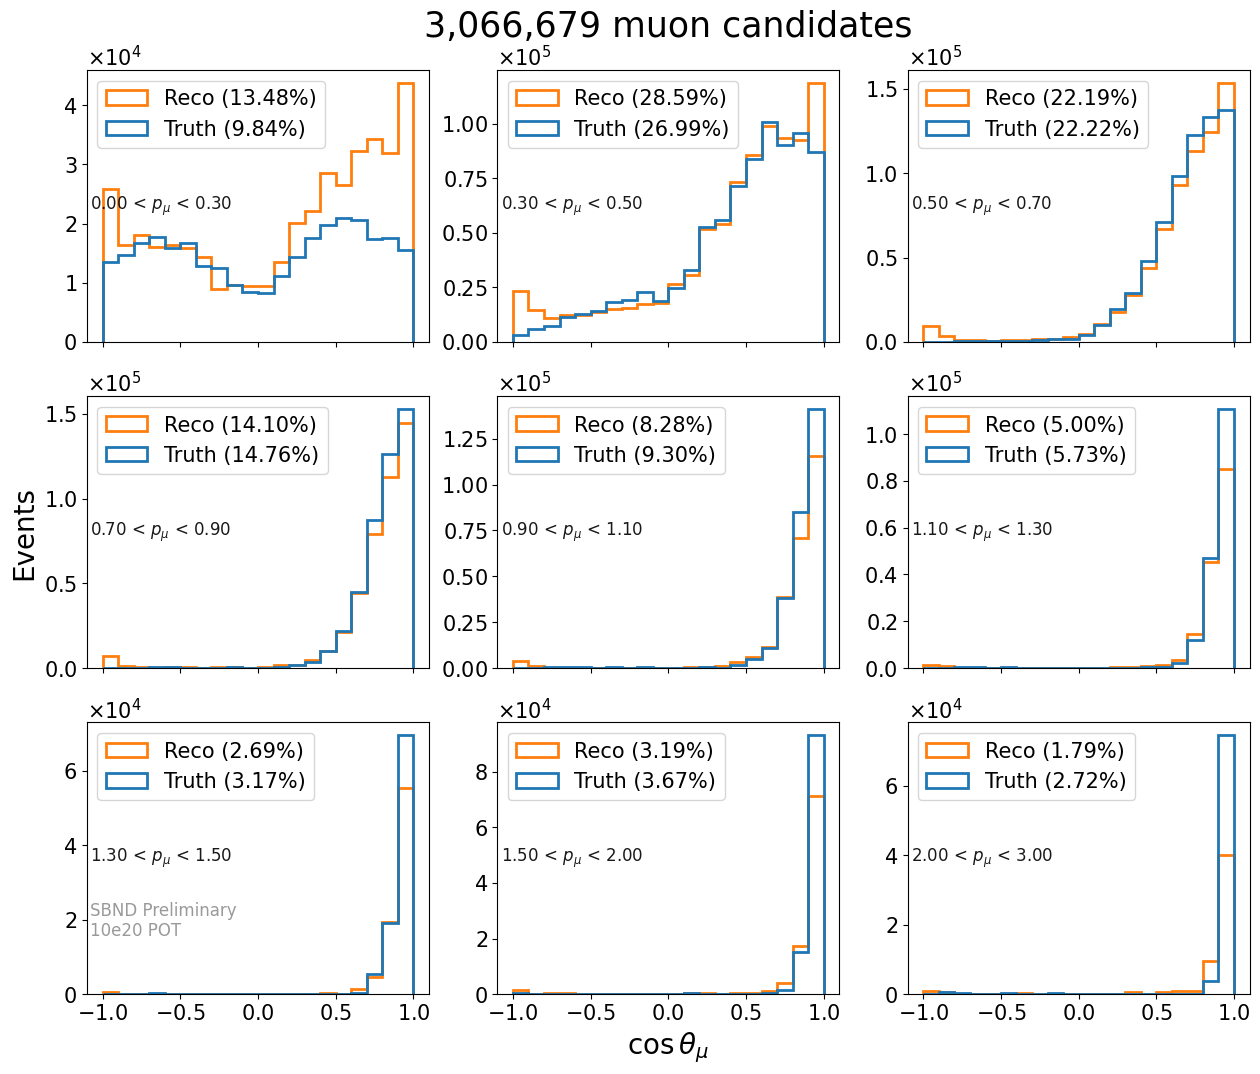

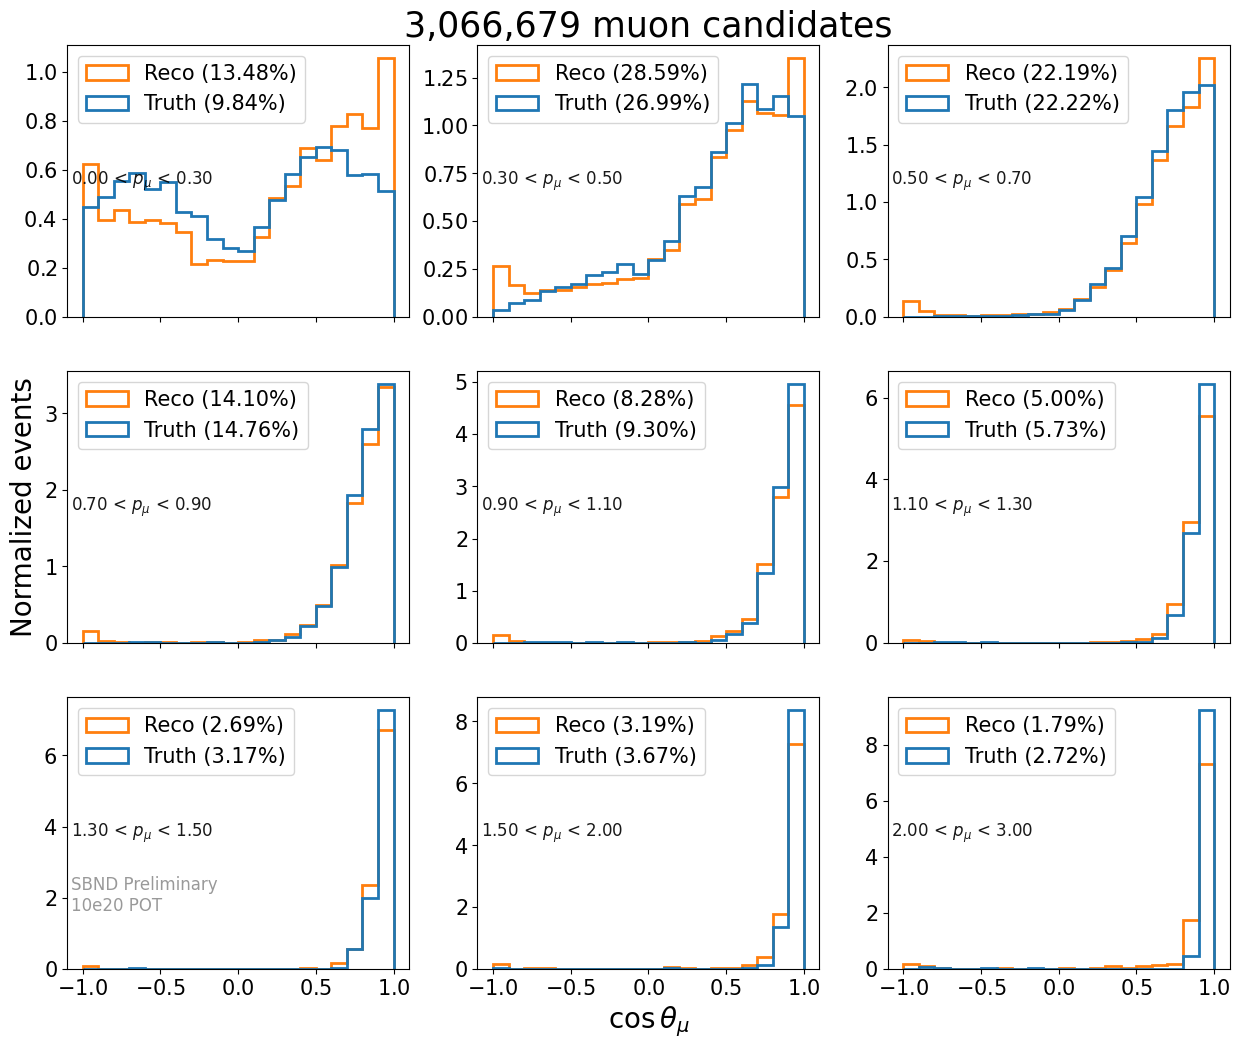

In [83]:
for j,dens in enumerate(['','_dens']):
  fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,12),sharex=True)
  for i,ax in enumerate(axs.flatten()):
    #Get muons within theta bins
    truth_muon_inrange = muon.data[(muon.data.truth.momentum_bin == i)]
    reco_muon_inrange = muon.data[(muon.data.momentum_bin == i)]
    
    #Get momenta
    ps_truth = truth_muon_inrange.truth.p.costheta
    ps_reco = reco_muon_inrange.costheta
    
    #Get weights
    weights_truth = truth_muon_inrange.genweight
    weights_reco = reco_muon_inrange.genweight
    
    #Get number of events from weights
    truth_inrange_count = np.sum(weights_truth)
    reco_inrange_count = np.sum(weights_reco)
    
    ax.hist([ps_truth,ps_reco],
            bins=np.arange(-1,1.1,0.1),
            weights=[weights_truth,weights_reco],
            histtype='step',
            lw=2,
            label=[f'Truth ({truth_inrange_count/total_events*100:.2f}%)', 
                  f'Reco ({reco_inrange_count/total_events*100:.2f}%)'],
            density=True if j == 1 else False)
    
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #plotters.set_style(ax)
    plotters.add_label(ax,f'{MOMENTUM_BINS[i]:.2f} < $p_\mu$ < {MOMENTUM_BINS[i+1]:.2f}',fontsize=12,alpha=0.9,where='centerleft')
    ax.legend()
  axs[2,1].set_xlabel(r'$\cos\theta_\mu$',fontsize=20)
  axs[0,1].set_title(rf'{round(muon.data.genweight.sum()):,} muon candidates',fontsize=25)
  axs[1,0].set_ylabel('Normalized events' if j == 1 else 'Events',fontsize=20)
  plotters.add_label(axs[2,0],LABEL,fontsize=12,alpha=0.8,color='gray',where='bottomishleft')
  if SAVE_PLOT:
    plotters.save_plot(f'theta_mu_momentum{dens}',fig=fig,folder_name=PLOT_DIR)
    #plt.close()

### 5.3 Reco w/ Event Type

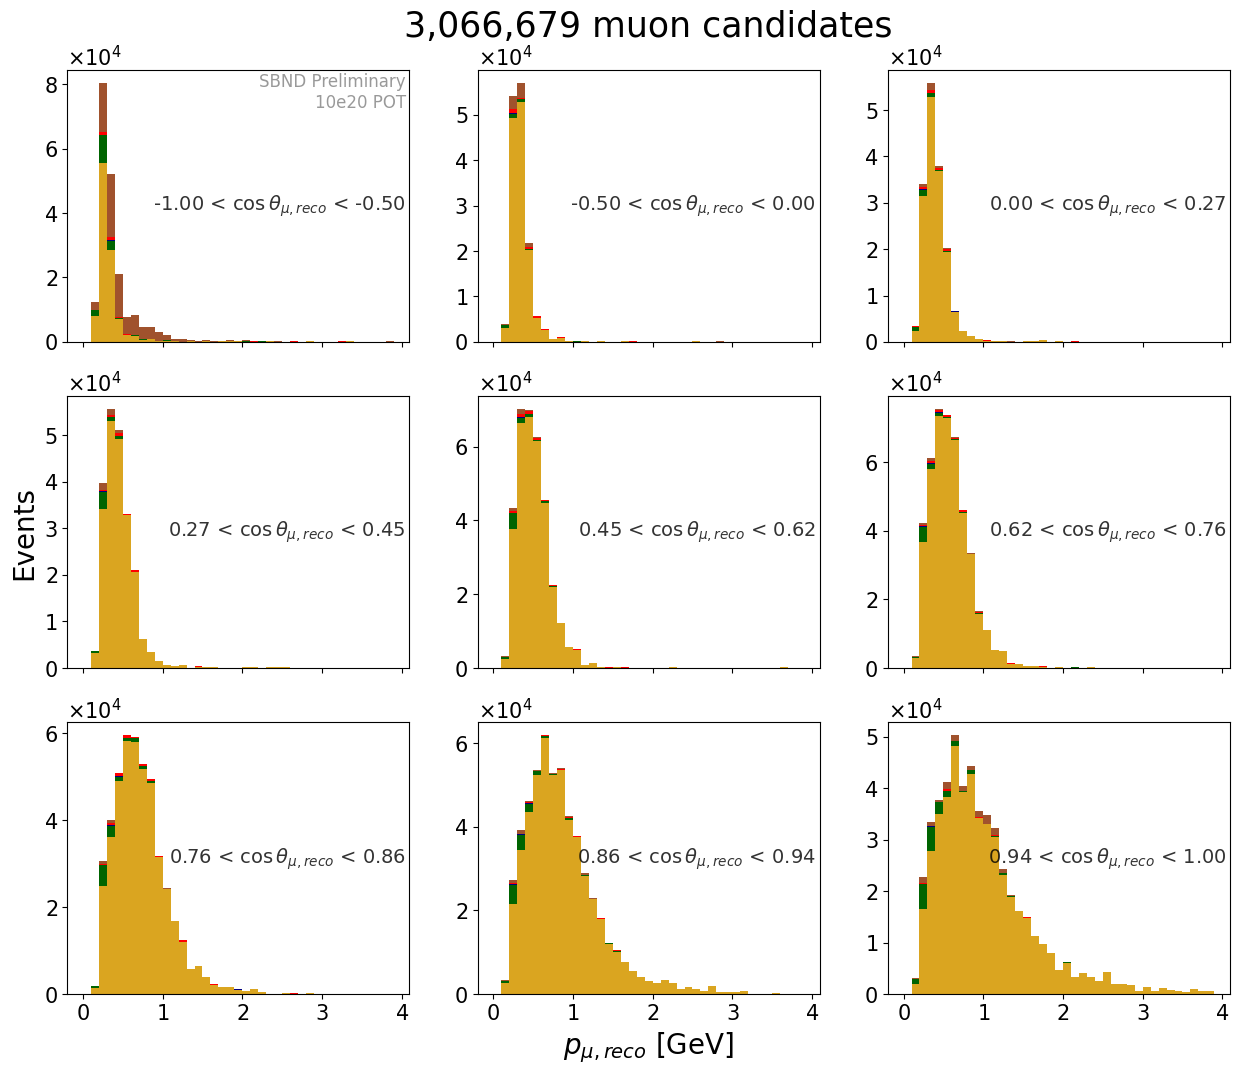

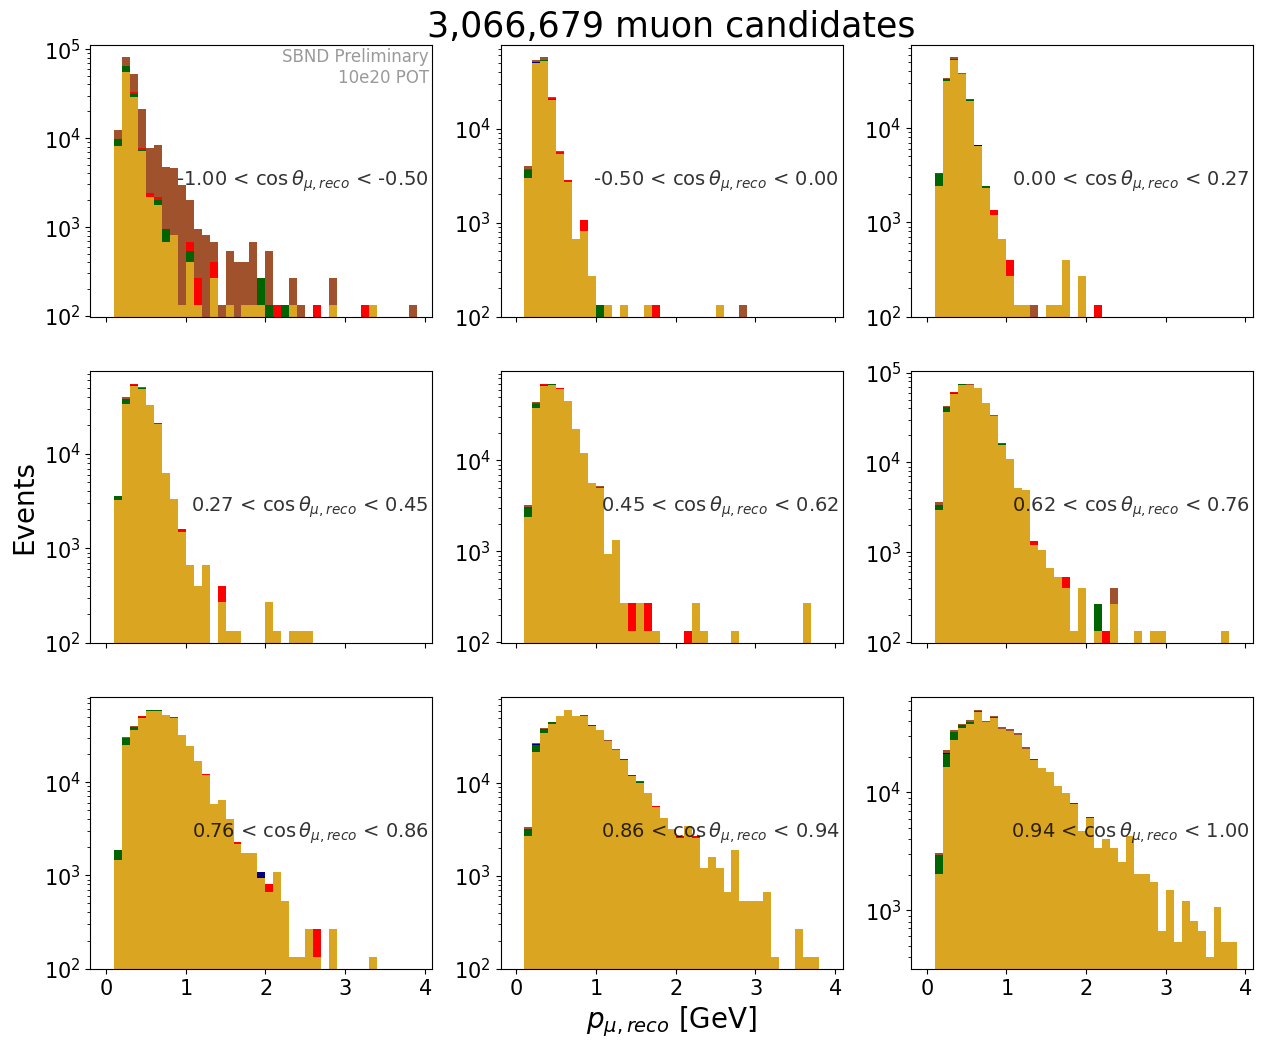

In [84]:
for j,yscale in enumerate(['linear','log']):
  fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,12),sharex=True)
  for i,ax in enumerate(axs.flatten()):
    #Get muons within theta bins  
    muons_inrange = [m[m.costheta_bin == i] for m in muon_events]
    
    #Get momenta
    ps = [m.p for m in muons_inrange]
    
    #Get weights
    weights = [m.genweight for m in muons_inrange]
    
    #Get number of events from weights
    inrange_counts = [np.sum(w) for w in weights]
    
    ax.hist(ps,
            bins=np.arange(0,4,0.1),
            weights=weights,
            histtype='barstacked',
            lw=2,
            label=EVENT_NAMES[1:],
            color=EVENT_COLORS[1:])
    
    #if i == 0: 
      #ax.legend()
    #  where = 'bottomright'
    #else:
    where = 'centerright'
    if yscale == 'log': 
      ax.set_yscale('log')
    else:
      ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #plotters.set_style(ax)
    plotters.add_label(ax,f'{COSTHETA_BINS[i]:.2f} < ' + r'$\cos\theta_{\mu,reco}$' + f' < {COSTHETA_BINS[i+1]:.2f}',fontsize=14,alpha=0.8,where=where)
  axs[2,1].set_xlabel(r'$p_{\mu,reco}$ [GeV]',fontsize=20)
  axs[0,1].set_title(rf'{round(muon.data.genweight.sum()):,} muon candidates',fontsize=25)
  axs[1,0].set_ylabel('Events',fontsize=20)
  plotters.add_label(axs[0,0],LABEL,fontsize=12,alpha=0.8,color='gray')
  if SAVE_PLOT:
    plotters.save_plot(f'momentum_mu_theta_events_{yscale}',fig=fig,folder_name=PLOT_DIR)
    #plt.close()

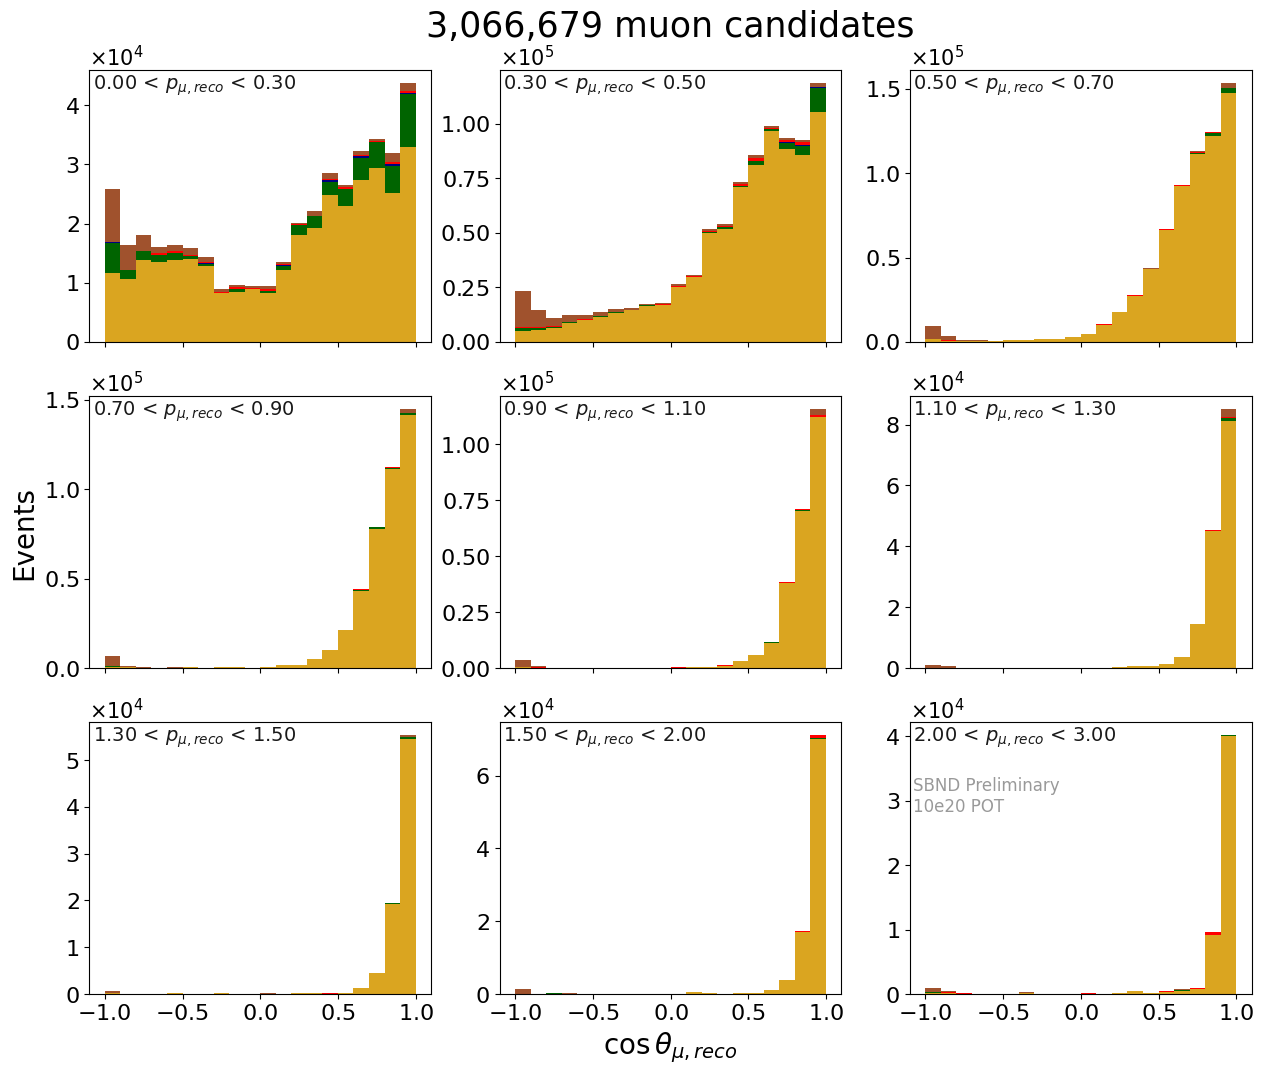

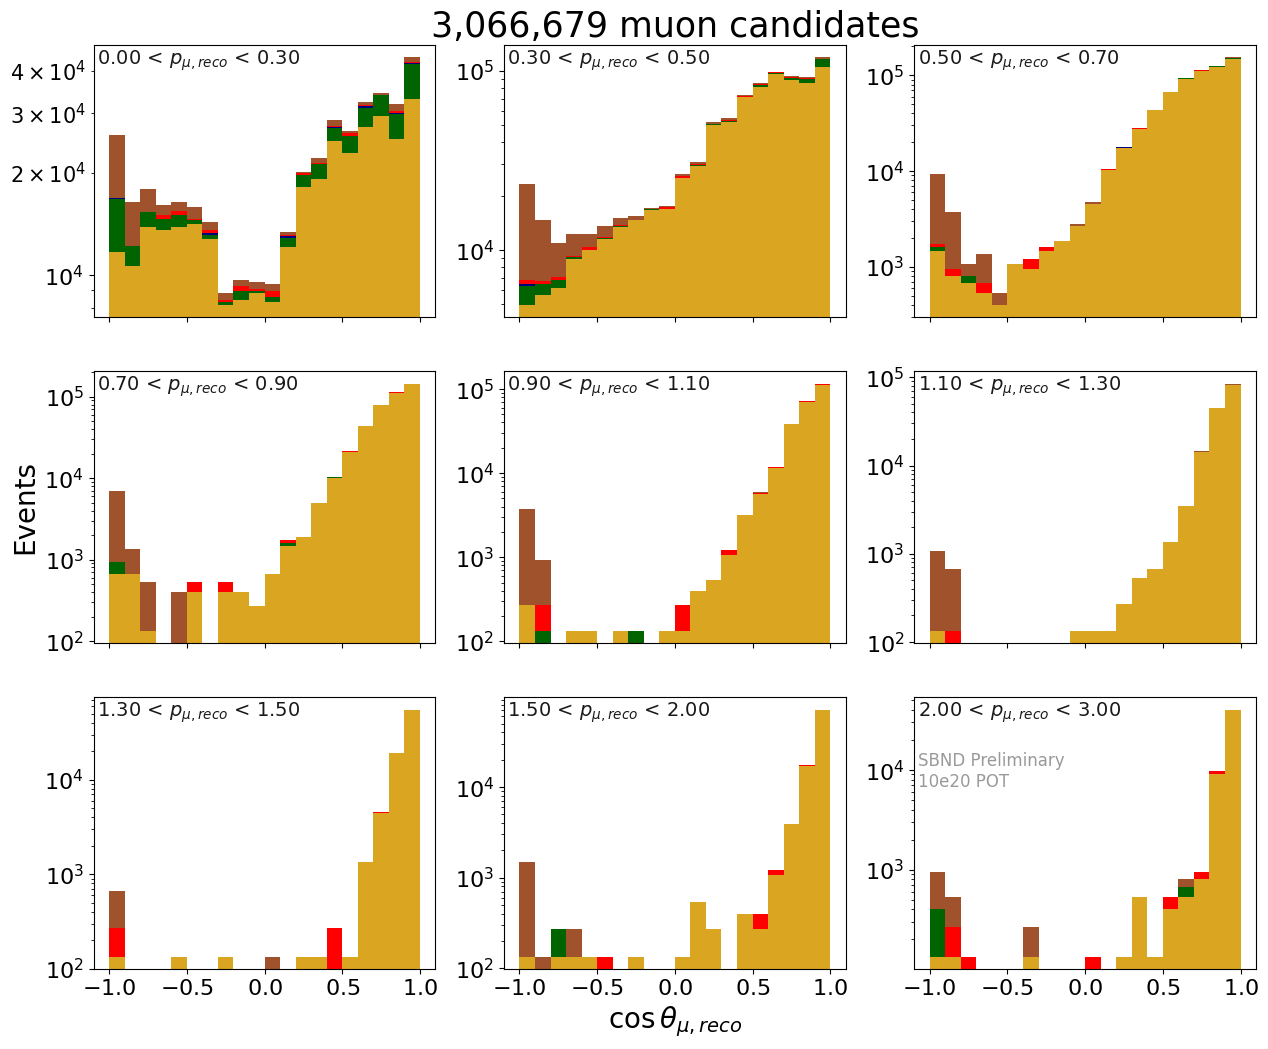

In [85]:
for j,yscale in enumerate(['linear','log']):
  fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,12),sharex=True)
  for i,ax in enumerate(axs.flatten()):
    #Get muons within momentum bins  
    muons_inrange = [m[m.momentum_bin == i] for m in muon_events]
    
    #Get momenta
    costhetas = [m.costheta for m in muons_inrange]
    
    #Get weights
    weights = [m.genweight for m in muons_inrange]
    
    #Get number of events from weights
    inrange_counts = [np.sum(w) for w in weights]
    
    ax.hist(costhetas,
            bins=np.arange(-1,1.1,0.1),
            weights=weights,
            histtype='barstacked',
            lw=2,
            label=EVENT_NAMES[1:],
            color=EVENT_COLORS[1:])
    
    where = 'topishleft'
    if i == 8: 
      #ax.legend()
      plotters.add_label(ax,LABEL,fontsize=12,alpha=0.8,color='gray',where=where)
    if yscale == 'log': ax.set_yscale('log')
    else: ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plotters.set_style(ax)
    plotters.add_label(ax,f'{MOMENTUM_BINS[i]:.2f}' + r' < $p_{\mu,reco}$ ' + f'< {MOMENTUM_BINS[i+1]:.2f}',fontsize=14,alpha=0.9,where='topleft')
  axs[2,1].set_xlabel(r'$\cos\theta_{\mu,reco}$',fontsize=20)
  axs[0,1].set_title(rf'{round(muon.data.genweight.sum()):,} muon candidates',fontsize=25)
  axs[1,0].set_ylabel('Events',fontsize=20)
  if SAVE_PLOT:
    plotters.save_plot(f'costheta_mu_momentum_events_{yscale}',fig=fig,folder_name=PLOT_DIR)
    #plt.close()

## 6 2D histograms w uncertainties

In [8]:
true_numucc = np.array((muon.data.event_type == 0).values,dtype=bool)
true_is_muon = np.array((muon.data.truth.p.pdg == 13).values,dtype=bool)
true_is_cont = np.array((muon.data.truth.p.cont_tpc).values,dtype=bool)
is_cont = np.array((muon.data.cont_tpc).values,dtype=bool)

In [9]:
SAVE_PLOT=True

In [10]:
#Energy
no_nan = np.array((~muon.data.energy.isna() & ~muon.data.truth.p.genE.isna()).values,dtype=bool)
for norm in [True]:
    for use_numucc in [True,False]:
        for use_muon in ['true_muon','']:
            for cont in ['reco_no', 'reco_cont', 'truth_no', 'truth_cont','']:
                for zoom in [False,True]:
                    fname = 'energy'
                    title = ''
                    label = LABEL
                    mask = no_nan
                    #Event filter
                    if use_numucc:
                        fname += '_numucc'
                        title += r'True $\nu_\mu$CC'
                        mask = true_numucc & no_nan
                    #PDG filter
                    if use_muon == 'true_muon':
                        fname += '_true_muon'
                        label += '\nTrue Muons'
                        mask = mask & true_is_muon
                    #Containment filter
                    if cont == 'reco_no':
                        fname += f'_{cont}'
                        label += '\nUncontained Reco'
                        mask = mask & ~is_cont
                    elif cont == 'reco_cont':
                        fname += f'_{cont}'
                        label += '\nContained Reco'
                        mask = mask & is_cont
                    elif cont == 'truth_no':
                        fname += f'_{cont}'
                        label += '\nUncontained True'
                        mask = mask & ~true_is_cont
                    elif cont == 'truth_cont':
                        fname += f'_{cont}'
                        label += '\nContained True'
                        mask = mask & true_is_cont
                    #Log scale
                    if norm:
                        fname += '_norm'
                        norm = LogNorm()
                        #title += ' (Log Scale)'
                    else:
                        norm = None
                    #Zoom in
                    if zoom:
                        bins = np.arange(0,1.55,0.05)
                        fname += '_zoom'
                        mask = mask & (muon.data.truth.p.genE < 1.5)
                    else:
                        bins = np.arange(0,3.,0.1)
                    x = muon.data.energy[mask]
                    y = muon.data.truth.p.genE[mask]
                    fig,(ax,ax2) = makeplot.plot_hist2d_frac_err(x,y,xlabel=r'$E_{\mu,reco}$ [GeV]',ylabel=r'$E_{\mu,true}$ [GeV]',bins=bins,cmap='Blues',plot_line=True,norm=norm
                                                                ,colorbar=True)
                    #Enforce a bias limit
                    ylims = ax2.get_ylim()
                    ax2.set_ylim([max(-2,ylims[0]),min(2,ylims[1])])
                    
                    #Add a stats box
                    mbe = np.mean(x-y)
                    mse = np.mean((x-y)**2)
                    rms = np.sqrt(mse)
                    var = np.var(x-y)
                    std = np.std(x-y)
                    
                    stats = r'$\left<E_{reco}-E_{true}\right>$ = '+ f'{mbe:.2f} GeV' + '\n' + fr'$\sigma$ = {std:.2f} GeV'
                    plotters.add_label(ax,stats,where='bottomright',color='red',size=12)
                    
                    #Set labels
                    ax.set_title(title)
                    ax.grid()
                    plotters.set_style(ax)
                    plotters.add_label(ax,label,where='topleft',color='red',size=12)
                    if SAVE_PLOT:
                        plotters.save_plot(fname,fig=fig,folder_name=f'{PLOT_DIR}/2dhists')
                        plt.close()
        #             break
        #         break
        #     break
        # break
    #break

In [11]:
#Costheta
bins = np.arange(-1,1.1,0.1)
no_nan = ~muon.data.costheta.isna() & ~muon.data.truth.p.costheta.isna()
for norm in [True]:
    for use_numucc in [True,False]:
        for use_muon in ['true_muon','']:
            for cont in ['reco_no', 'reco_cont', 'truth_no', 'truth_cont','']:
                for zoom in [False,True]:
                    fname = 'costheta'
                    title = ''
                    label = LABEL
                    mask = no_nan
                    #Event filter
                    if use_numucc:
                        fname += '_numucc'
                        title += r'True $\nu_\mu$CC'
                        mask = true_numucc & no_nan
                    #PDG filter
                    if use_muon == 'true_muon':
                        fname += '_true_muon'
                        label += '\nTrue Muons'
                        mask = mask & true_is_muon
                    #Containment filter
                    if cont == 'reco_no':
                        fname += f'_{cont}'
                        label += '\nUncontained Reco'
                        mask = mask & ~is_cont
                    elif cont == 'reco_cont':
                        fname += f'_{cont}'
                        label += '\nContained Reco'
                        mask = mask & is_cont
                    elif cont == 'truth_no':
                        fname += f'_{cont}'
                        label += '\nUncontained True'
                        mask = mask & ~true_is_cont
                    elif cont == 'truth_cont':
                        fname += f'_{cont}'
                        label += '\nContained True'
                        mask = mask & true_is_cont
                    #Log scale
                    if norm:
                        fname += '_norm'
                        norm = LogNorm()
                        #title += ' (Log Scale)'
                    else:
                        norm = None
                    #Zoom in
                    if zoom:
                        bins = np.arange(0.5,1.025,0.025)
                        fname += '_zoom'
                        mask = mask & (muon.data.truth.p.costheta > 0.5)
                    else:
                        bins = np.arange(-1,1.1,0.1)
                    x = muon.data.costheta[mask]
                    y = muon.data.truth.p.costheta[mask]
                    fig,(ax,ax2) = makeplot.plot_hist2d_frac_err(x,y,xlabel=r'$\cos\theta_{\mu,reco}$',ylabel=r'$\cos\theta_{\mu,true}$',bins=bins,cmap='Blues',plot_line=True,norm=norm
                                                                ,colorbar=True)
                    #Enforce a bias limit
                    ylims = ax2.get_ylim()
                    ax2.set_ylim([max(-2,ylims[0]),min(2,ylims[1])])
                    
                    #Add a stats box
                    mbe = np.mean(x-y)
                    mse = np.mean((x-y)**2)
                    rms = np.sqrt(mse)
                    var = np.var(x-y)
                    std = np.std(x-y)
                    
                    stats = r'$\left<\cos\theta_{reco}-\cos\theta_{true}\right>$ = '+ f'{mbe:.3f}' + '\n' + fr'$\sigma$ = {std:.3f}'
                    plotters.add_label(ax,stats,where='bottomright',color='red',size=12)
                    ax.grid()
                    ax.set_title(title)
                    plotters.set_style(ax)
                    plotters.add_label(ax,label,where='topleft',color='red',size=12)
                    if SAVE_PLOT:
                    #if False:
                        plotters.save_plot(fname,fig=fig,folder_name=f'{PLOT_DIR}/2dhists')
                        plt.close()
                    #break
    #             break
    #         break
    #     break
    # break

In [43]:
#cont vs uncontained
for norm in [False]:
    for use_numucc in [True,False,None]:
        for use_muon in ['true_muon','']:
                fname = 'cont'
                title = ''
                label = LABEL
                mask = [True]*len(muon.data)
                #Event filter
                if use_numucc:
                    fname += '_numucc'
                    title += r'True $\nu_\mu$CC'
                    mask = true_numucc
                elif use_numucc == False:
                    fname += '_background'
                    title += r'Background'
                    mask = ~true_numucc
                #PDG filter
                if use_muon == 'true_muon':
                    fname += '_true_muon'
                    label += '\nTrue Muons'
                    mask = mask & true_is_muon
                #Log scale
                if norm:
                    fname += '_norm'
                    norm = LogNorm()
                    #title += ' (Log Scale)'
                else:
                    norm = None
                x = muon.data.cont_tpc.values[mask]
                y = muon.data.truth.p.cont_tpc.values[mask]
                hist = build_matrix(x,y,n_classes=2)
                fig,ax = makeplot.draw_confusion_matrix_binned(hist,class_names=['Uncontained','Contained'],xlabel='Reconstructed',ylabel='True')
                ax.set_title(title)
                plotters.set_style(ax)
                plotters.add_label(ax,label,where='bottomright',color='red',size=10)
                #if SAVE_PLOT:
                if True:
                    plotters.save_plot(fname,fig=fig,folder_name=f'{PLOT_DIR}/2dhists')
                    plt.close()
                

In [44]:
pdgs = muon.data.truth.p.pdg
pdg,counts = np.unique(abs(pdgs),return_counts=True)
counts_dict = dict(zip(pdg,counts/np.sum(counts)))
print('all events:',counts_dict)

pdgs = muon.data[muon.data.event_type == 0].truth.p.pdg
pdg,counts = np.unique(abs(pdgs),return_counts=True)
counts_dict = dict(zip(pdg,counts/np.sum(counts)))
print('numucc events:',counts_dict)

all events: {11.0: 4.374070510016621e-05, 13.0: 0.9314145744029394, 22.0: 0.00013122211530049865, 211.0: 0.04793981278978217, 321.0: 0.0003061849357011635, 2212.0: 0.02012072434607646, 1000010020.0: 4.374070510016621e-05}
numucc events: {11.0: 4.729921483303377e-05, 13.0: 0.9619241320594079, 22.0: 9.459842966606754e-05, 211.0: 0.026818654810330148, 321.0: 9.459842966606754e-05, 2212.0: 0.01102071705609687}


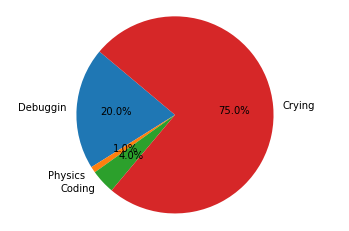

In [28]:
# Data to plot
labels = 'Debuggin', 'Physics', 'Coding', 'Crying'
sizes = [20, 1, 4, 75]

# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# #TODO: make a line plot of correctly identified muons as function of blah. IDC now though
# #PID - assign 0 to photon, 1 to electron, 2 to muon, 3 to pion, 4 to proton, 5 to other
# pids = np.zeros(len(muon.data))
# true_pids = pids.copy()

# #Get pid masks
# muon_mask = abs(muon.data.truth.p.pdg) == 13
# pion_mask = abs(muon.data.truth.p.pdg) == 211
# proton_mask = abs(muon.data.truth.p.pdg) == 2212
# electron_mask = abs(muon.data.truth.p.pdg) == 11
# photon_mask = abs(muon.data.truth.p.pdg) == 22

# true_pids[muon_mask] = 2
# true_pids[pion_mask] = 3
# true_pids[proton_mask] = 4
# true_pids[electron_mask] = 1
# true_pids[photon_mask] = 0


# for use_numucc in [True,False]:
#     for cont in ['reco_no', 'reco_cont', 'truth_no', 'truth_cont','']:
#         for var in ['reco_energy','reco_costheta','true_energy','true_costheta']:
#             fname = f'pid_{var}'
#             title = ''
#             label = LABEL
#             mask = no_nan
#             #Containment filter
#             if cont == 'reco_no':
#                 fname += f'_{cont}'
#                 label += '\nUncontained Reco'
#                 mask = mask & ~is_cont
#             elif cont == 'reco_cont':
#                 fname += f'_{cont}'
#                 label += '\nContained Reco'
#                 mask = mask & is_cont
#             elif cont == 'truth_no':
#                 fname += f'_{cont}'
#                 label += '\nUncontained True'
#                 mask = mask & ~true_is_cont
#             elif cont == 'truth_cont':
#                 fname += f'_{cont}'
#                 label += '\nContained True'
#                 mask = mask & true_is_cont
#             #Get x val
#             if var == 'reco_energy':
#                 x = muon.data.energy[mask]
#             elif var == 'reco_costheta':
#                 x = muon.data.costheta[mask]
#             elif var == 'true_energy':
#                 x = muon.data.truth.p.startE[mask]
#             elif var == 'true_costheta':
#                 x = muon.data.truth.p.costheta[mask]
#             y = true_pids[mask]
        
        
        


In [81]:
np.arange(0.5,2.5,1)

array([0.5, 1.5])

In [170]:
np.unique(muon.data.event_type,return_counts=True)

(array([0, 1, 2, 3, 4]), array([26318,   737,    22,  1093,  1783]))

In [178]:
np.unique(abs(muon.data.truth.p.pdg),return_counts=True)

(array([1.10000000e+01, 1.30000000e+01, 2.11000000e+02, 3.21000000e+02,
        2.21200000e+03, 1.00001002e+09]),
 array([    1, 28019,  1312,     4,   615,     2]))

In [179]:
np.unique(abs(muon.data.truth.p.pdg),return_counts=True)[1]/len(muon.data)

array([3.33856375e-05, 9.35432177e-01, 4.38019564e-02, 1.33542550e-04,
       2.05321671e-02, 6.67712750e-05])

In [ ]:

#plt.hist(muon.data.truth.p.startE,bins=bins)
badE = muon.data[muon.data.truth.p.startE < kMuonMass+1e-4]
goodE = muon.data[muon.data.truth.p.startE > kMuonMass+1e-4]np.unique(badE.truth.p.cont_tpc,return_counts=True),np.unique(goodE.truth.p.cont_tpc,return_counts=True)
badE.event_type